In [1]:
#importar as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Importar os dados
df = pd.read_csv('dataset_voos_limpo_backup.csv')

In [3]:
#Ler os dados
df['partida_prevista'] = pd.to_datetime(df['partida_prevista'])

/tmp/ipykernel_38448/3337922205.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['partida_prevista'] = pd.to_datetime(df['partida_prevista'])


## Nova estilização dos gráficos para montar o infográfico

### 1) Total de voos realizados

In [4]:
# --- Configuração de Cores "Flight On Time" ---
BG_COLOR = "#0b1424"        # Fundo do infográfico
COLOR_PONTUAL = "#1e293b"   # Slate Dark (No horário)
COLOR_ATRASADO = "#06b6d4"  # Cyan (Atrasados - Destaque)
CYAN_FILL = "#06b6d4"       # Preenchimento
CYAN_LINE = "#06b6d4"       # Linha Cyan Vibrante
TEXT_COLOR = "#94a3b8"       # Slate 400
WHITE = "#ffffff"
GRID_COLOR = "#1e293b"       # Slate 800 (Grade sutil)

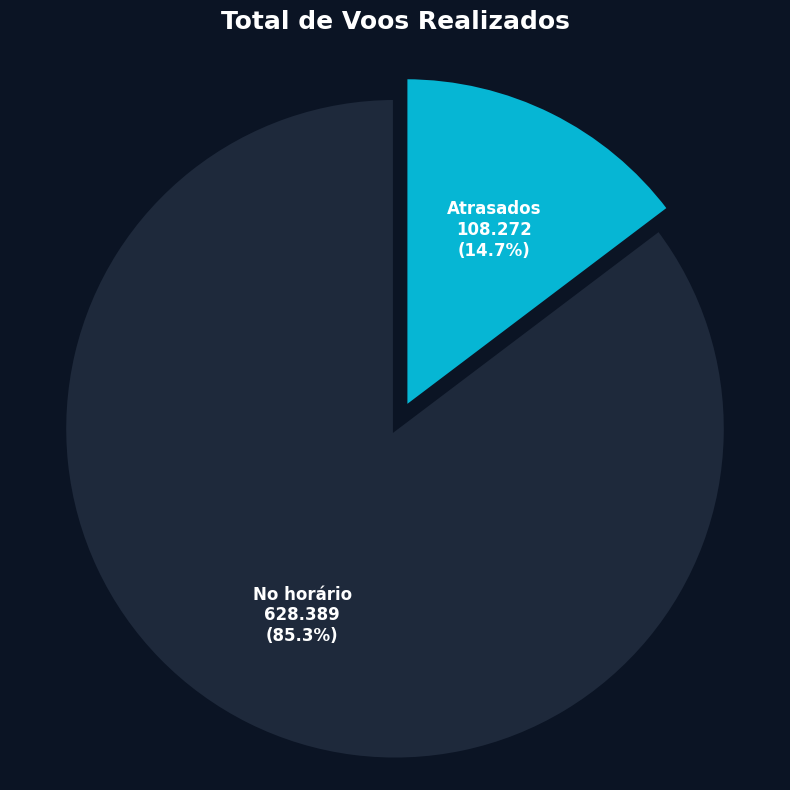

In [25]:
# 1. Preparação dos Dados
counts = df['situacao_voo'].value_counts() 
labels_map = {0: 'No horário', 1: 'Atrasados'}
labels = [labels_map.get(i, i) for i in range(len(counts))]
values = counts.values
total = sum(values)

# 2. Configuração da Figura
plt.figure(figsize=(8,8), facecolor=BG_COLOR)
ax = plt.subplot(111, facecolor=BG_COLOR)

# 3. Plotagem do Gráfico de Pizza
explode = (0.02, 0.05) if len(values) > 1 else (0,)
colors = [COLOR_PONTUAL, COLOR_ATRASADO]

wedges, _ = ax.pie(
    values, 
    explode=explode, 
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': BG_COLOR, 'linewidth': 3}
)

# 4. Adicionando Rótulos Internos para Melhor Leitura
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    # Posicionamento centralizado dentro da fatia (raio aproximado de 0.65)
    y = 0.65 * plt.np.sin(plt.np.deg2rad(ang))
    x = 0.65 * plt.np.cos(plt.np.deg2rad(ang))
    
    percentage = (values[i] / total) * 100
    label_text = f"{labels[i]}\n{values[i]:,}\n({percentage:.1f}%)".replace(',', '.')
    
    # Texto em branco para contraste direto sobre as cores das fatias
    ax.text(
        x, y, label_text, 
        ha='center', va='center', 
        fontsize=12, 
        fontweight='bold',
        color=WHITE
    )

# 5. Finalização
plt.title('Total de Voos Realizados', fontsize=18, fontweight='bold', color=WHITE, pad=20)
plt.axis('equal') 
plt.tight_layout()
plt.savefig('img/Total_voos_realizados.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### 2. Voos atrasados por hora

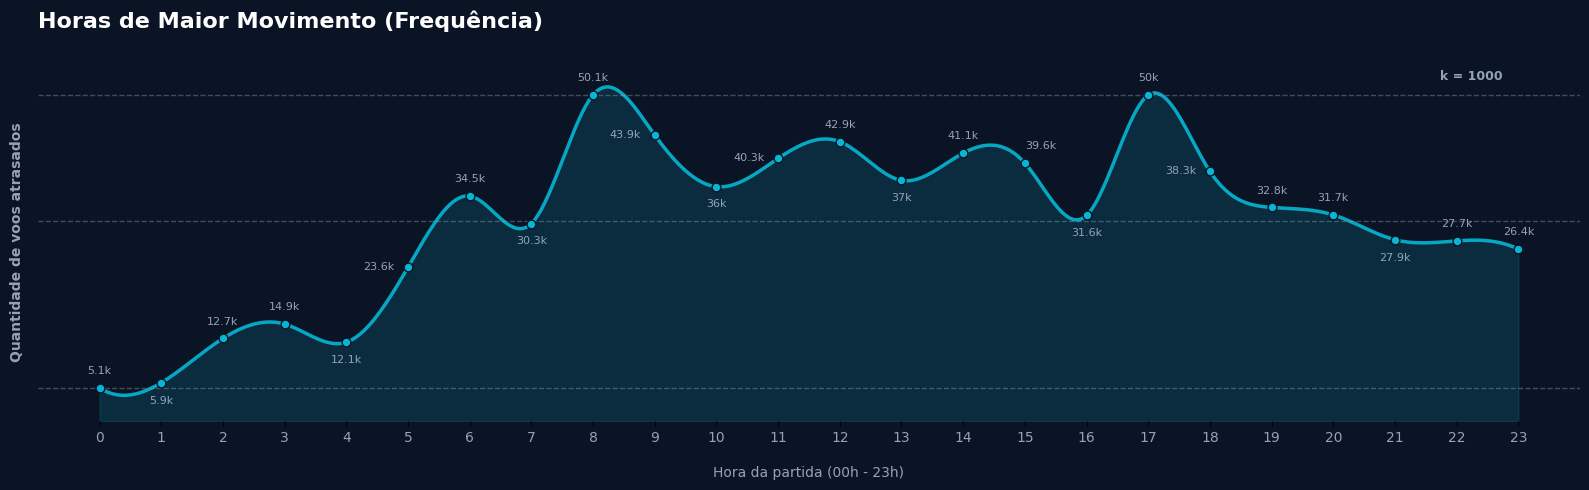

In [58]:
import numpy as np
from scipy.interpolate import make_interp_spline

def format_k(value):
    if value >= 1000:
        return f"{value/1000:.1f}k".replace('.0k', 'k')
    return str(int(value))

# 1. Preparação dos Dados
atrasos_por_hora = df['partida_hora'].value_counts().sort_index()
atrasos_por_hora = atrasos_por_hora.reindex(range(24), fill_value=0)

# Suavização das linhas (Spline Interpolation)
x = atrasos_por_hora.index
y = atrasos_por_hora.values
X_Y_Spline = make_interp_spline(x, y)
X_smooth = np.linspace(x.min(), x.max(), 500)
Y_smooth = X_Y_Spline(X_smooth)
Y_smooth = np.clip(Y_smooth, 0, None) # Garante que não haja valores negativos na interpolação

# 2. Configuração da Figura
plt.figure(figsize=(16, 5), facecolor=BG_COLOR)
ax = plt.gca()
ax.set_facecolor(BG_COLOR)

# 3. Plotagem do Gráfico de Área (Suavizado)
plt.plot(X_smooth, Y_smooth, color=CYAN_LINE, linewidth=2.5, alpha=0.9)
plt.fill_between(X_smooth, Y_smooth, color=CYAN_FILL, alpha=0.15)

## 3.5. Cálculo e Inserção das Linhas de Referência (Horizontal)
v_min = atrasos_por_hora.min()
v_max = atrasos_por_hora.max()
v_med = atrasos_por_hora.mean()

# Adicionando as linhas tracejadas horizontais
for v_ref, label_ref in zip([v_min, v_med, v_max], ['Mín', 'Méd', 'Máx']):
    plt.axhline(y=v_ref, color=TEXT_COLOR, linestyle='--', alpha=0.4, linewidth=1)
    # Rótulo à direita da linha (opcional)
    #plt.text(max(x)*1.02, v_ref, label_ref, color=TEXT_COLOR, fontsize=8, va='center', fontweight='bold')

# Inserindo as marcações "o" nos pontos originais
plt.scatter(x, y, color=CYAN_LINE, s=40, marker='o', edgecolors=BG_COLOR, zorder=5)

# 4. Anotações de Valores (Mantidas nos pontos originais)
top_pos = [0, 2, 3, 6, 8, 12, 14, 15, 17, 19, 20, 22, 23]
bottom_pos = [1, 4, 7, 10, 13, 16, 21]

for x_orig, y_orig in atrasos_por_hora.items():
    label = format_k(y_orig)
    if x_orig == 15:    
        ax.annotate(label, (x_orig, y_orig), textcoords="offset points", xytext=(0, 10), ha='left', color=TEXT_COLOR, fontsize=8)
    elif x_orig in top_pos:
        ax.annotate(label, (x_orig, y_orig), textcoords="offset points", xytext=(0, 10), ha='center', color=TEXT_COLOR, fontsize=8)
    elif x_orig in bottom_pos:
        ax.annotate(label, (x_orig, y_orig), textcoords="offset points", xytext=(0, -15), ha='center', color=TEXT_COLOR, fontsize=8)
    else:
        ax.annotate(label, (x_orig, y_orig), textcoords="offset points", xytext=(-10, 0), ha='right', va='center', color=TEXT_COLOR, fontsize=8)

# 5, 6. Estilização dos Eixos e Grade
for spine in ax.spines.values():
    spine.set_visible(False)

ax.yaxis.grid(True, linestyle='-', color=GRID_COLOR, alpha=0.3)
ax.xaxis.grid(False)

plt.title('Horas de Maior Movimento (Frequência)', fontsize=16, fontweight='bold', color='white', pad=25, loc='left')
plt.xlabel('Hora da partida (00h - 23h)', fontsize=10, color=TEXT_COLOR, labelpad=15)
plt.ylabel('Quantidade de voos atrasados', color=TEXT_COLOR, fontsize=10, fontweight='bold', labelpad=10)

plt.yticks([], color='none')
plt.xticks(range(0, 24), fontsize=10, color=TEXT_COLOR)

plt.xlim(-1, 24)
plt.ylim(0, max(atrasos_por_hora.values) * 1.1)

plt.text(0.95, 0.95, 'k = 1000', transform=ax.transAxes, color=TEXT_COLOR, fontsize=9, ha='right', fontweight='bold')

plt.tight_layout()
plt.savefig('img/atrasos_por_hora.png', dpi=300, bbox_inches='tight',transparent=True, pad_inches=0.05)
plt.show()

### 3. Média de minutos de atrasos por hora

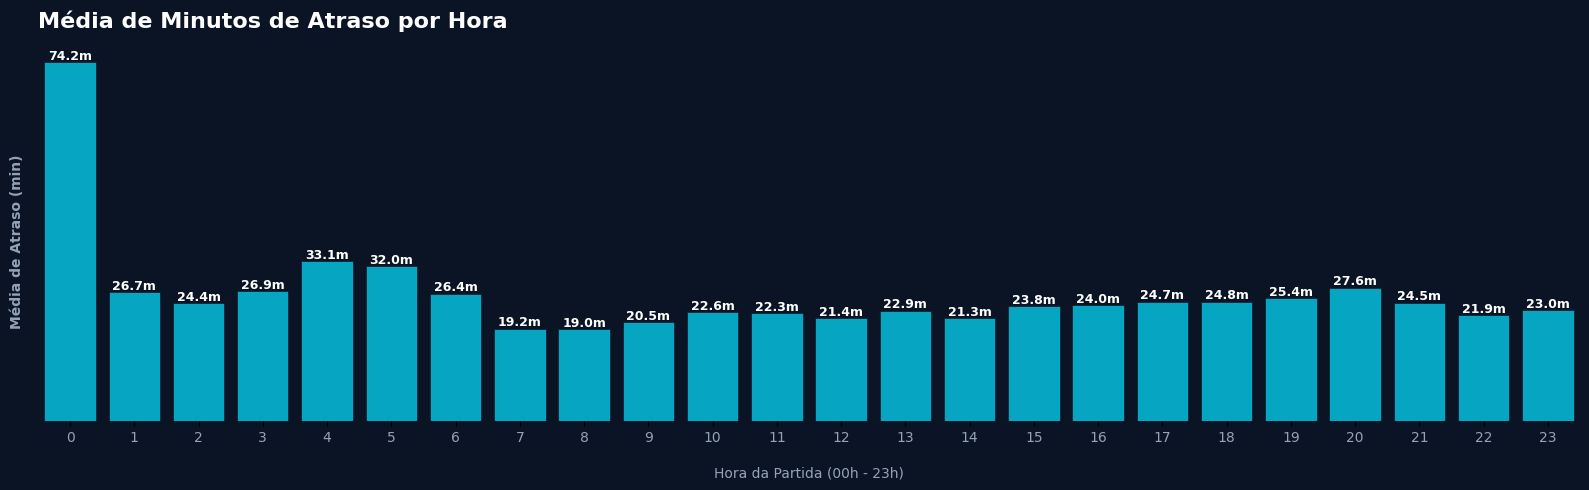

In [48]:
# Cálculo da média de atraso por hora (apenas voos atrasados)
voos_atrasados = df[df['atraso_minutos'] > 0]
media_atraso_por_hora = voos_atrasados.groupby('partida_hora')['atraso_minutos'].mean()

# Dados
x = media_atraso_por_hora.index
y = media_atraso_por_hora.values

# Preparação das cores (Lógica dinâmica: > 70 é Cyan)
#cores_barras = [CYAN_FILL if v > 70 else COLOR_PONTUAL for v in y]

# 1. Configuração da Figura
fig, ax = plt.subplots(figsize=(16, 5), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 2. Plotagem do gráfico de barras
bars = ax.bar(x, y, color=CYAN_FILL, edgecolor=BG_COLOR, linewidth=0.5, alpha=0.9, zorder=3)

# 3. Adicionar valores nas barras
for i, v in enumerate(y):
    ax.text(x[i], v + 0.5, f'{v:.1f}m', ha='center', fontsize=9, color=WHITE, fontweight='bold')


# 4, 5, 6. Estilização dos Eixos e Grade
for spine in ax.spines.values():
    spine.set_visible(False)

ax.yaxis.grid(True, linestyle='-', color=GRID_COLOR, alpha=0.3)
ax.xaxis.grid(False)

plt.title('Média de Minutos de Atraso por Hora', fontsize=16, fontweight='bold', color=WHITE, pad=25, loc='left')
plt.xlabel('Hora da Partida (00h - 23h)', fontsize=10, color=TEXT_COLOR, labelpad=15)
plt.ylabel('Média de Atraso (min)', color=TEXT_COLOR, fontsize=10, fontweight='bold', labelpad=10)
plt.yticks([], color='none')
plt.xticks(range(0, 24), fontsize=10, color=TEXT_COLOR)
plt.xlim(-0.5, 23.5)
plt.ylim(0, max(y) * 1)
plt.tight_layout()
plt.savefig('img/media_atraso_por_hora.png', dpi=300, bbox_inches='tight', facecolor=BG_COLOR, transparent=True)
plt.show()

### 4. Atrasos por dias da semana

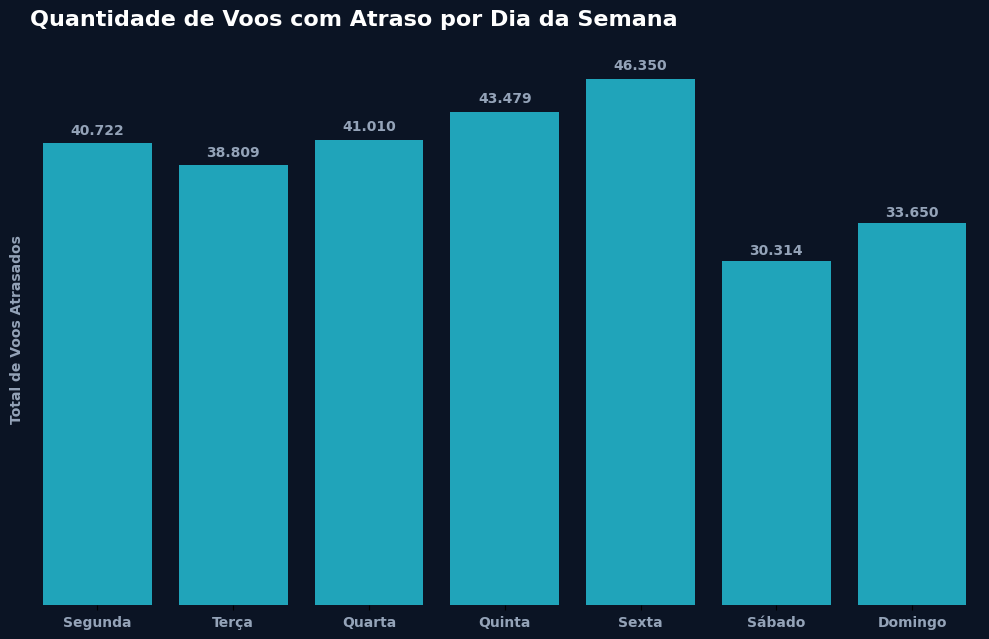

In [53]:
# Configura o fundo da figura
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['axes.facecolor'] = BG_COLOR

# --- Atrasos por Dia da Semana ---
# 1. Mapear os números para nomes dos dias (0 = Segunda, 6 = Domingo)
mapa_dias = {
    0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 
    4: 'Sexta', 5: 'Sábado', 6: 'Domingo'
}

# 2. Filtrar apenas os voos com atraso
voos_com_atraso = df[df['atraso_minutos'] > 0]

# 3. Contar atrasos por dia e reordenar de Segunda a Domingo
atrasos_por_dia = voos_com_atraso['partida_dia_semana'].value_counts().sort_index()
atrasos_por_dia.index = atrasos_por_dia.index.map(mapa_dias)

# 5. Plotagem
plt.figure(figsize=(10, 6.5), dpi=100)
ax = sns.barplot(
    x=atrasos_por_dia.index, 
    y=atrasos_por_dia.values, 
    color=CYAN_FILL,
    linewidth=0
)

# --- Estilização Avançada ---

# Remover bordas (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Título e Eixos
plt.title('Quantidade de Voos com Atraso por Dia da Semana', fontsize=16, fontweight='bold', color=WHITE, pad=20, loc='left')
plt.xlabel('', fontsize=10)
plt.ylabel('Total de Voos Atrasados', fontsize=10, fontweight='bold', color=TEXT_COLOR)

# Customizar Grade (apenas horizontal)
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color=GRID_COLOR)
ax.set_axisbelow(True)

# Customizar Ticks
plt.xticks(fontsize=10, fontweight='600', color=TEXT_COLOR)
plt.yticks([])

# Adicionar valores formatados no topo de cada barra
for i, v in enumerate(atrasos_por_dia.values):
    ax.text(
        i, 
        v + (v * 0.02), 
        f'{v:,}'.replace(',', '.'),
        ha='center', 
        fontsize=10, 
        fontweight='bold', 
        color=TEXT_COLOR
    )

plt.tight_layout()
plt.savefig('img/atrasos_por_dia_semana.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

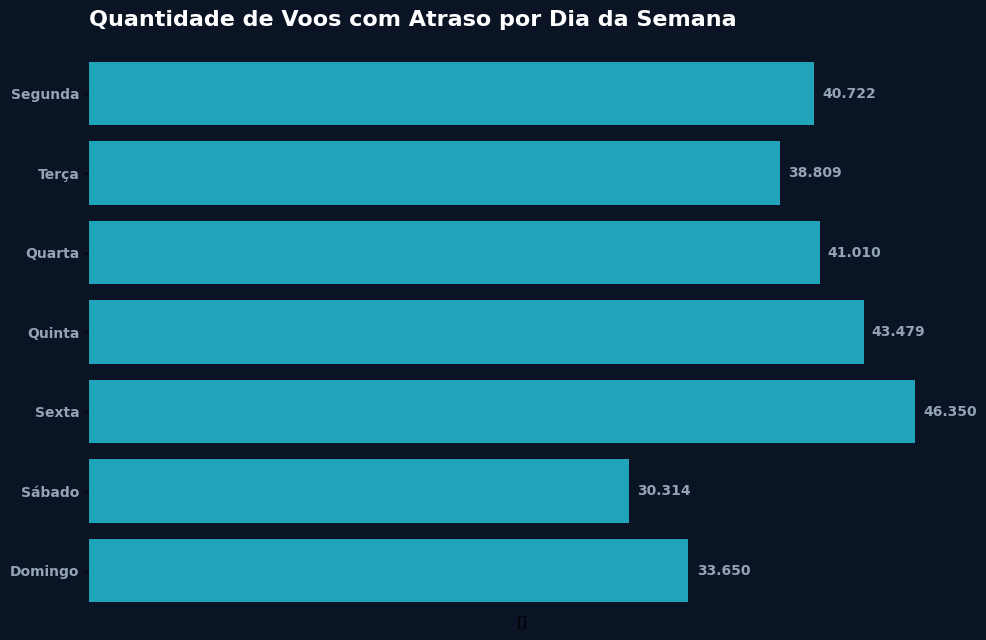

In [50]:
# Configura o fundo da figura
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['axes.facecolor'] = BG_COLOR

# --- Atrasos por Dia da Semana ---
# 1. Mapear os números para nomes dos dias (0 = Segunda, 6 = Domingo)
mapa_dias = {
    0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 
    4: 'Sexta', 5: 'Sábado', 6: 'Domingo'
}

# 2. Filtrar apenas os voos com atraso
voos_com_atraso = df[df['atraso_minutos'] > 0]

# 3. Contar atrasos por dia e reordenar de Segunda a Domingo
atrasos_por_dia = voos_com_atraso['partida_dia_semana'].value_counts().sort_index()
atrasos_por_dia.index = atrasos_por_dia.index.map(mapa_dias)

# 5. Plotagem (Barras Horizontais)
plt.figure(figsize=(10, 6.5), dpi=100)
ax = sns.barplot(
    y=atrasos_por_dia.index, 
    x=atrasos_por_dia.values, 
    color=CYAN_FILL,
    linewidth=0
)

# --- Estilização Avançada ---

# Remover bordas (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Título e Eixos
plt.title('Quantidade de Voos com Atraso por Dia da Semana', fontsize=16, fontweight='bold', color=WHITE, pad=20, loc='left')
plt.ylabel('', fontsize=10)
plt.xlabel([])#('Total de Voos Atrasados', fontsize=10, fontweight='bold', color=TEXT_COLOR)

# Customizar Grade (apenas vertical)
ax.xaxis.grid(True, linestyle='--', alpha=0.3, color=GRID_COLOR)
ax.set_axisbelow(True)

# Customizar Ticks
plt.yticks(fontsize=10, fontweight='600', color=TEXT_COLOR)
plt.xticks([])

# Adicionar valores formatados ao lado de cada barra
for i, v in enumerate(atrasos_por_dia.values):
    ax.text(
        v + (atrasos_por_dia.values.max() * 0.01), 
        i, 
        f'{v:,}'.replace(',', '.'),
        va='center', 
        fontsize=10, 
        fontweight='bold', 
        color=TEXT_COLOR
    )

plt.tight_layout()
plt.savefig('img/atrasos_por_dia_semana.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### 5. Quantidade de voos por mês

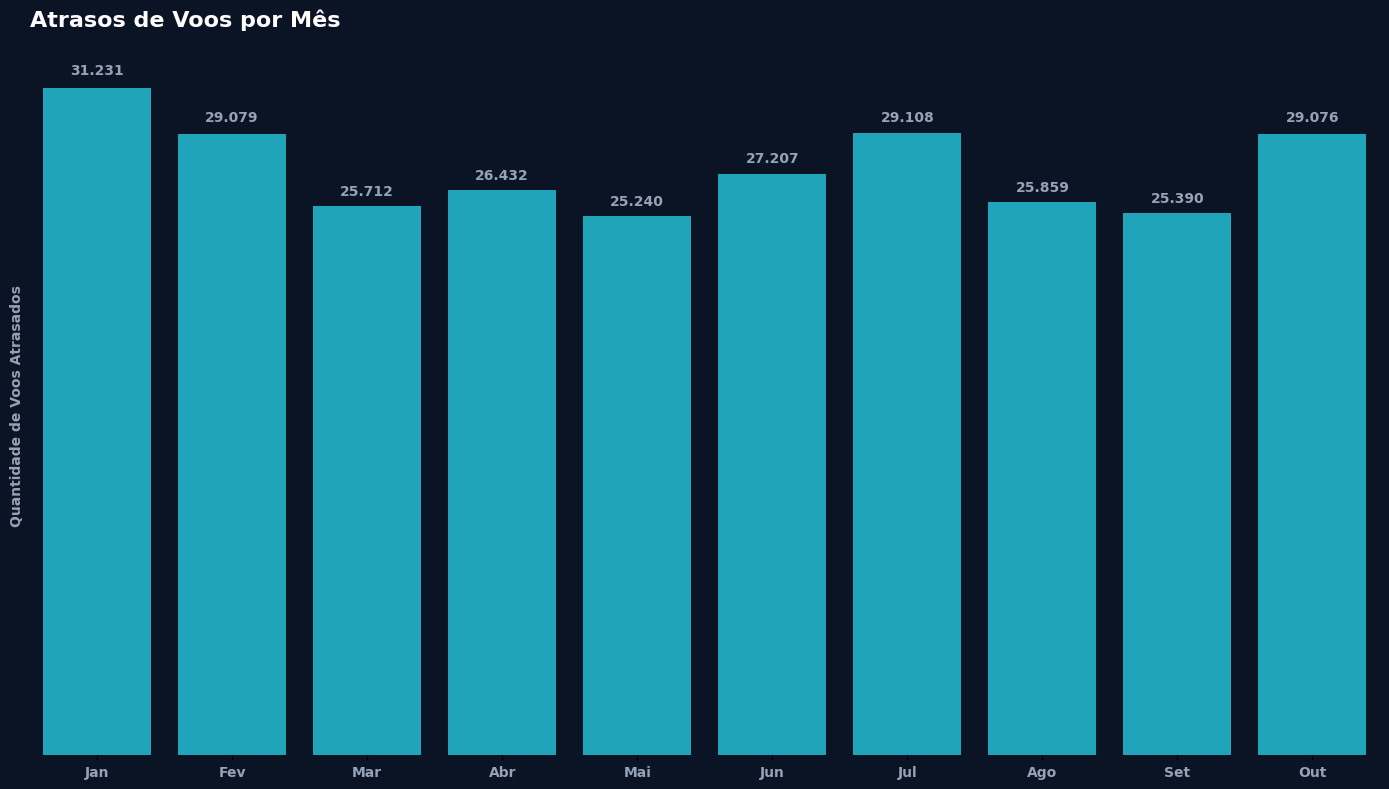

In [59]:
# Configura o fundo da figura
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['axes.facecolor'] = BG_COLOR

# 1. Mapeamento dos meses (conforme seu código original)
mapa_meses = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

# 2. Filtragem e Agrupamento
voos_com_atraso = df[df['atraso_minutos'] > 0]
atrasos_por_mes = voos_com_atraso['partida_mes'].value_counts().sort_index()
atrasos_por_mes.index = atrasos_por_mes.index.map(mapa_meses)

# 3. Plotagem
plt.figure(figsize=(14, 8), dpi=100)
ax = sns.barplot(
    x=atrasos_por_mes.index, 
    y=atrasos_por_mes.values, 
    color=CYAN_FILL,
    linewidth=0 # Retira a borda branca das colunas
)

# --- Estilização Avançada ---

# Remover bordas (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Título e Eixos
plt.title('Atrasos de Voos por Mês', fontsize=16, fontweight='bold', color='white', pad=20, loc='left')
plt.xlabel('', fontsize=10) # Remove label do eixo X (os nomes dos meses já bastam)
plt.ylabel('Quantidade de Voos Atrasados', fontsize=10, fontweight='bold', color=TEXT_COLOR) # Adiciona legenda no eixo vertical

# Customizar Grade (apenas horizontal)
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color=TEXT_COLOR)
ax.set_axisbelow(True)

# Customizar Ticks (Textos dos meses e valores)
plt.xticks(fontsize=10, fontweight='600', color=TEXT_COLOR)
plt.yticks([]) # Remove os números do eixo Y para um visual mais "Dashboard"

# Adicionar valores formatados no topo de cada barra (com separador de milhar)
for i, v in enumerate(atrasos_por_mes.values):
    ax.text(
        i, 
        v + (v * 0.02), 
        f'{v:,}'.replace(',', '.'), # Formato brasileiro 100.000
        ha='center', 
        fontsize=10, 
        fontweight='bold', 
        color=TEXT_COLOR
    )

plt.tight_layout()
plt.savefig('img/atrasos_por_mes.png', dpi=300, bbox_inches='tight', transparent=True) # Salva o arquivo no computador
plt.show()